# Partie A – Machine Learning avec Scikit-learn

Ce notebook répond à l'énoncé :
- Séparation des données (train/test)
- Pipeline scikit-learn (OneHotEncoder + RandomForestClassifier)
- Évaluation (accuracy, recall, f1-score)
- Interprétation des variables importantes
- Discussion sur l'amélioration de la cantine

Le code est basé sur le script `train_model.py`.

## 1. Importer les bibliothèques nécessaires

Nous allons importer les modules essentiels pour le traitement des données et le machine learning.

In [36]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Charger les données et séparer en train/test

Nous allons charger le fichier `cantine.csv`, vérifier les colonnes, puis séparer les données en jeu d'entraînement (70%) et test (30%).

In [37]:
base_dir = os.path.dirname(os.path.dirname(os.path.abspath("train_model.py")))
data_path = os.path.join(base_dir, 'data', 'cantine.csv')
df = pd.read_csv(data_path)
expected = ['age', 'classe', 'type_repas', 'calories', 'cout_repas', 'freq_consommation', 'satisfaction', 'recommande']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Colonnes manquantes dans le CSV: {missing}")
target = 'recommande'
X = df.drop(columns=[target])
y = df[target].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Taille train: {X_train.shape[0]}, test: {X_test.shape[0]}")

Taille train: 1050, test: 450


**Pourquoi séparer les données ?**

séparer train/test permet d'estimer la performance généralisable du modèle et de limiter le sur-apprentissage. Sans set de test, on risque d'optimiser les hyperparamètres ou la structure pour s'adapter au bruit du jeu d'entraînement et d'avoir une performance trompeuse en production


## 3. Pipeline scikit-learn : encodage et modélisation

Nous allons construire un pipeline avec un encodage des variables catégorielles et un classificateur RandomForest.

In [38]:
numeric_features = ['age', 'calories', 'cout_repas', 'freq_consommation', 'satisfaction']
categorical_features = ['classe', 'type_repas']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features),
])
clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', min_samples_leaf=1, max_features='sqrt')
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', clf)
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['classe', 'type_repas']),
                                                 ('num', 'passthrough',
                                                  ['age', 'calories',
                                                   'cout_repas',
                                                   'freq_consommation',
                                                   'satisfaction'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

## 4. Évaluation du modèle

Calculons l'accuracy, le recall et le f1-score sur le jeu de test.

In [39]:
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
print(f"Recall:   {rec:.3f}")
print(f"F1-score: {f1:.3f}")
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.678
Recall:   0.811
F1-score: 0.761
              precision    recall  f1-score   support

           0      0.578     0.448     0.505       165
           1      0.717     0.811     0.761       285

    accuracy                          0.678       450
   macro avg      0.648     0.630     0.633       450
weighted avg      0.666     0.678     0.667       450



## 5. Interprétation : variables les plus importantes

Identifions les deux variables les plus importantes pour la prédiction.

In [40]:
ohe = pipe.named_steps['preprocess'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_features)
feature_names = list(ohe_features) + numeric_features
importances = pipe.named_steps['model'].feature_importances_
top2_idx = np.argsort(importances)[-2:][::-1]
top2 = [(feature_names[i], float(importances[i])) for i in top2_idx]
print("Top 2 variables les plus importantes :")
for name, imp in top2:
    print(f"- {name}: importance={imp:.4f}")

Top 2 variables les plus importantes :
- calories: importance=0.2801
- cout_repas: importance=0.2569


## 6. Discussion : comment ces résultats peuvent aider l’école

Les variables les plus importantes (par exemple, calories et coût du repas) indiquent les leviers d’amélioration pour la cantine :
- Adapter l’offre nutritionnelle selon les besoins des élèves
- Réfléchir à la tarification pour maximiser la satisfaction

Une analyse régulière permet d’orienter les décisions de l’administration scolaire pour améliorer la qualité et l’accessibilité de la cantine.

## 7. Visualisation des importances des variables

Nous allons afficher un graphique pour interpréter l'importance de chaque variable dans la prédiction, avec le pourcentage pour chaque variable.

C:\Users\MEACEDRICEMMANUELASS\AppData\Local\Temp\ipykernel_6012\2350273707.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance (%)', y='Variable', data=importances_df, palette='viridis')


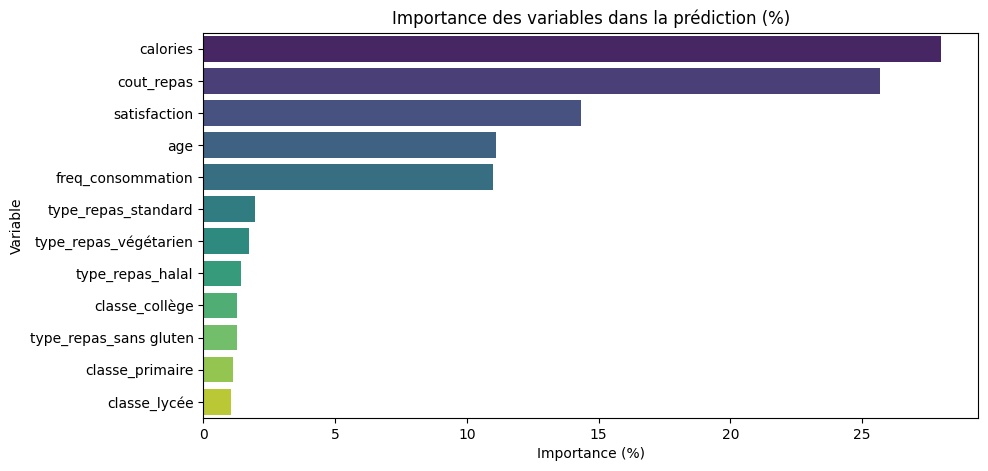

Variables les moins importantes :
- type_repas_sans gluten: 1.28%
- classe_primaire: 1.14%
- classe_lycée: 1.04%


In [41]:
# Correction : importer matplotlib et seaborn au début de la cellule
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des pourcentages
importances_percent = 100 * importances / importances.sum()

# Création du DataFrame pour le graphique
importances_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance (%)': importances_percent
}).sort_values('Importance (%)', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance (%)', y='Variable', data=importances_df, palette='viridis')
plt.title('Importance des variables dans la prédiction (%)')
plt.xlabel('Importance (%)')
plt.ylabel('Variable')
plt.show()

# Affichage des variables les moins importantes
print("Variables les moins importantes :")
for name, imp in importances_df.tail(3).values:
    print(f"- {name}: {imp:.2f}%")